# Air Quality Prediction

This notebook demonstrates a simple machine learning workflow for predicting Air Quality Index (AQI) using city-level air pollution data.

## Objective
- Load and preprocess air quality data
- Perform exploratory data analysis
- Handle missing values and outliers
- Build and evaluate regression models to predict AQI

---

In [3]:
# Import necessary libraries for data analysis, visualization, and machine learning
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the air quality dataset
df=pd.read_csv('data/city_day.csv')
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [5]:
# Convert 'Date' column to datetime and extract day, month, year features
df['Date']=pd.to_datetime(df['Date'])

df['day']=df['Date'].dt.day
df['month']=df['Date'].dt.month
df['year']=df['Date'].dt.year

In [6]:
# Drop the original 'Date' column after feature extraction
df.drop('Date',axis=1,inplace=True)

In [7]:
# Display a random sample from the dataframe
df.sample()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,day,month,year
22960,Mumbai,NaN,NaN,NaN,NaN,107.05,NaN,2.43,NaN,NaN,0.0,0.0,0.0,NaN,NaN,10,1,2018


In [8]:
# Check for missing values in each column
null=df.isnull().sum()
null[null>0]

PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64

In [9]:
# Drop columns not needed
df.drop('Xylene',axis=1,inplace=True)
df.drop('AQI_Bucket',axis=1,inplace=True)

In [10]:
# Fill missing values in pollutant columns with their median values
df['PM2.5']=df['PM2.5'].fillna(df['PM2.5'].median())
df['PM10']=df['PM10'].fillna(df['PM10'].median())
df['NO']=df['NO'].fillna(df['NO'].median())
df['NO2']=df['NO2'].fillna(df['NO2'].median())
df['NOx']=df['NOx'].fillna(df['NOx'].median())
df['NH3']=df['NH3'].fillna(df['NH3'].median())
df['CO']=df['CO'].fillna(df['CO'].median())
df['SO2']=df['SO2'].fillna(df['SO2'].median())
df['O3']=df['O3'].fillna(df['O3'].median())
df['Benzene']=df['Benzene'].fillna(df['Benzene'].median())
df['Toluene']=df['Toluene'].fillna(df['Toluene'].median())
df['AQI']=df['AQI'].fillna(df['AQI'].median())

In [11]:
# Check for duplicate rows in the dataframe
df.duplicated().sum()

np.int64(0)

In [12]:
# Display another random sample from the dataframe
df.sample()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI,day,month,year
10319,Delhi,112.86,167.6,24.6,32.71,45.12,36.05,10.15,19.48,38.45,4.04,9.07,309.0,1,4,2015


In [13]:
# Encode the 'City' column using label encoding
le=LabelEncoder()

df['City']=le.fit_transform(df['City'])

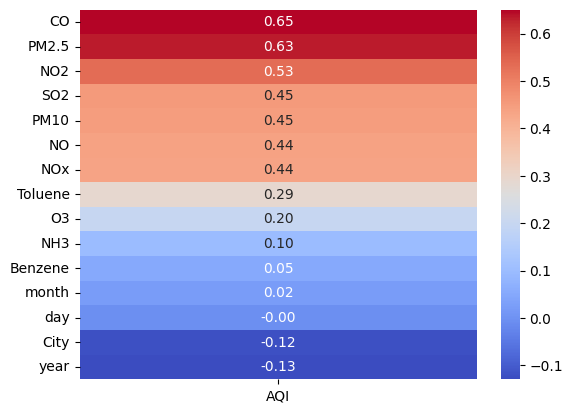

In [14]:
# Analyze correlation of features with AQI and plot heatmap
aqi_cor=df.corr()['AQI'].sort_values(ascending=False)
aqi_cor=aqi_cor.drop('AQI')

sns.heatmap(aqi_cor.to_frame(),annot=True,fmt='0.02f',cmap='coolwarm')
plt.show()

In [15]:
# Drop less relevant features for modeling
df=df.drop(['City','year','month','day','Benzene','NH3','O3','Toluene','NOx','PM10'],axis=1)

In [16]:
# Display a sample after feature selection
df.sample()

,PM2.5,NO,NO2,CO,SO2,AQI
1350,16.28,26.67,57.19,26.67,50.26,447.0


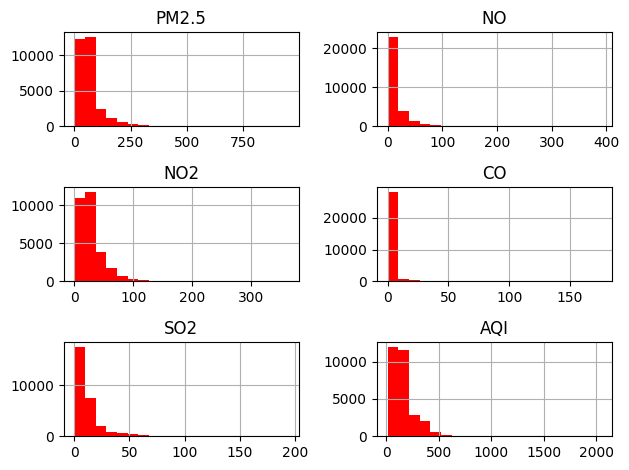

In [17]:
# Plot histograms of features to visualize distributions
df.hist(color='red',bins=20)
plt.tight_layout()
plt.show()

In [18]:
# Apply log transformation to reduce skewness in selected features
df['PM2.5'] = np.log1p(df['PM2.5'])
df['NO'] = np.log1p(df['NO'])
df['NO2'] = np.log1p(df['NO2'])
df['CO'] = np.log1p(df['CO'])
df['SO2'] = np.log1p(df['SO2'])
df['AQI'] = np.log1p(df['AQI'])

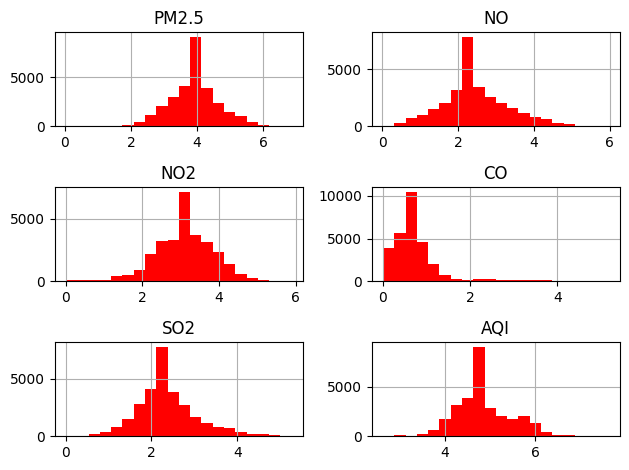

In [19]:
# Plot histograms again after log transformation
df.hist(color='red',bins=20)
plt.tight_layout()
plt.show()

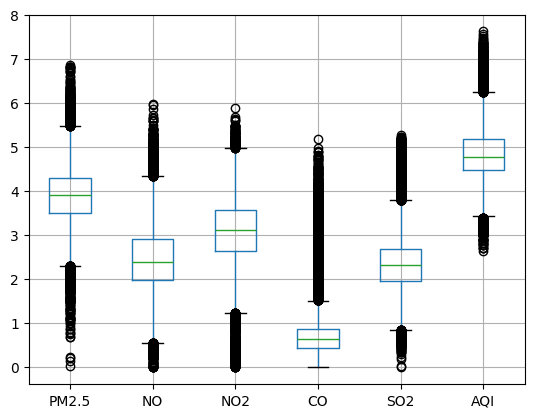

In [20]:
# Visualize feature distributions using boxplot
df.boxplot()
plt.show()

In [21]:
# Detect outliers in features using z-score
from scipy import stats

z_score = np.abs(stats.zscore(df['PM2.5']))
outliers=df[z_score>2]
print(f'\nNo of outliers in PM2.5 : {outliers.shape[0]}')


z_score = np.abs(stats.zscore(df['NO']))
outliers=df[z_score>2]
print(f'\nNo of outliers in NO : {outliers.shape[0]}')


z_score = np.abs(stats.zscore(df['NO2']))
outliers=df[z_score>2]
print(f'\nNo of outliers in NO2 : {outliers.shape[0]}')


z_score = np.abs(stats.zscore(df['CO']))
outliers=df[z_score>2]
print(f'\nNo of outliers in CO : {outliers.shape[0]}')


z_score = np.abs(stats.zscore(df['SO2']))
outliers=df[z_score>2]
print(f'\nNo of outliers in SO2 : {outliers.shape[0]}')


z_score = np.abs(stats.zscore(df['AQI']))
outliers=df[z_score>2]
print(f'\nNo of outliers in AQI : {outliers.shape[0]}')


No of outliers in PM2.5 : 1710

No of outliers in NO : 1945

No of outliers in NO2 : 1494

No of outliers in CO : 1543

No of outliers in SO2 : 1837

No of outliers in AQI : 1318


In [22]:
# Remove outliers using IQR method, excluding AQI column
def outlier_removal(df,exclude_column):
  for col in df.columns:
    if col == exclude_column:
      continue
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df=df[(df[col]>=lower_bound) & (df[col]<=upper_bound)]
  return df

df_cleaned = outlier_removal(df,exclude_column='AQI')
df_cleaned

,PM2.5,NO,NO2,CO,SO2,AQI
0,3.903386,0.652325,2.955951,0.652325,3.354804,4.779123
1,3.903386,0.678034,2.814810,0.678034,3.240637,4.779123
3,3.903386,0.993252,2.969388,0.993252,2.975019,4.779123
9,3.903386,2.387845,2.084429,0.636577,2.228939,4.779123
34,4.402442,1.214913,3.170945,1.214913,3.285787,5.686975
...,...,...,...,...,...,...
29524,2.670694,1.193922,3.117950,0.343590,2.218116,4.356709
29526,2.773838,2.161022,3.260402,0.385262,2.256541,3.737670
29527,3.233961,1.486140,3.298057,0.418710,2.618855,4.262680
29528,3.174297,1.492904,3.418710,0.392042,2.242835,4.234107


In [23]:
# Update the dataframe with cleaned data
df=df_cleaned

In [24]:
# Select features and split data into train and test sets
x=df[['CO','PM2.5','NO','NO2','SO2']]
y=df['AQI']

x_test,x_train,y_test,y_train = train_test_split(x,y,test_size=0.2,random_state=42)

In [25]:
# Train a linear regression model
model = LinearRegression()
model.fit(x_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [26]:
# Make predictions and evaluate model performance
y_pred=model.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
r2=r2_score(y_test,y_pred)

In [27]:
# Print regression metrics
print(f"MSE: {mse:0.2f}, RMSE: {rmse:0.2f}, R-squared: {r2:0.2f}")

MSE: 0.07, RMSE: 0.26, R-squared: 0.73


# *Now checking with 2 scaling methods.*

In [28]:
# Import scalers for feature normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [29]:
# Apply MinMax scaling to features
features = ['CO','PM2.5','NO','NO2','SO2']

scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df[features])

df_scaled = pd.DataFrame(scaled_data,columns=features,index=df.index)



In [30]:
# Display a sample of the scaled dataframe
df_scaled.sample()

,CO,PM2.5,NO,NO2,SO2
18893,0.584384,0.565632,0.938371,0.454195,0.813505


In [31]:
# Use scaled features for train-test split
x=df_scaled
y=df['AQI']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [32]:
# Train linear regression model on scaled data
model = LinearRegression()
model.fit(x_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [33]:
# Evaluate model performance on scaled data
y_pred=model.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
r2=r2_score(y_test,y_pred)

In [34]:
# Print regression metrics for scaled model
print(f"MSE: {mse:0.2f}, RMSE: {rmse:0.2f}, R-squared: {r2:0.2f}")

MSE: 0.06, RMSE: 0.25, R-squared: 0.74


In [35]:
# Apply Standard scaling to features
features = ['CO','PM2.5','NO','NO2','SO2']

scaler = StandardScaler()

scaled_data = scaler.fit_transform(df[features])

df_scaled2 = pd.DataFrame(scaled_data,columns=features,index=df.index)



In [36]:
# Use standard scaled features for train-test split
x=df_scaled2
y=df['AQI']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [37]:
# Train linear regression model on standard scaled data
model = LinearRegression()
model.fit(x_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [38]:
# Evaluate model performance on standard scaled data
y_pred=model.predict(x_test)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
r2=r2_score(y_test,y_pred)

In [39]:
# Print regression metrics for standard scaled model
print(f"MSE: {mse:0.2f}, RMSE: {rmse:0.2f}, R-squared: {r2:0.2f}")

MSE: 0.06, RMSE: 0.25, R-squared: 0.74


## Conclusion

In this notebook, we built and evaluated linear regression models to predict Air Quality Index (AQI) using city-level air pollution data.

We performed three tests:
- **Outliers removed - Non Scaled Model:** Evaluated using MSE, RMSE, and R-squared metrics.
- **MinMax Scaled Model:** Evaluated using MSE, RMSE, and R-squared metrics.
- **Standard Scaled Model:** Evaluated using MSE, RMSE, and R-squared metrics.

Both approaches provided insights into the effectiveness of feature scaling on model performance. The results can be used to further improve air quality prediction models or to compare with other machine learning techniques.

---

In [ ]:
import joblib
joblib.dump(model,'air_quality_model.pkl')